In [1]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess) 

In [2]:
import numpy as np
import functools
import random
import datetime
import scipy
import h5py
import os
import pathlib
import nrrd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib
import sys
import json
import skimage
from skimage import io, draw
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [1445]:
classification_model = load_model('f5_dnsnet1.5_3mm.eph04-sen0.99-spe0.78.hdf5', compile = False)

In [1446]:
detection_model = load_model('fold5.epoch4-loss0.80.hdf5', compile = False)

In [1447]:
def create_dataset_detection(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2) #113
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.359))
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                image_c =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                image_c = np.transpose(image_c, (2, 1, 0))
                image_c = image_c[::-1, :, :]
            
                img_data_array.append(image_c)
                # reading markups
                j = 0
            if (file.endswith(".json")) and j<1:
                #json_filename = glob(img_folder +  '/*.json')[-1]
                #data = open(json_filename,'r')
                json_path= os.path.join(img_folder, dir1, file)
                data = open(json_path,'r')
                
                jsondata = data.read()
                # Parse
                obj=json.loads(jsondata)
                list=obj['markups']
                # getting LPS coordinates
                points1 = list[0]["controlPoints"][0]["position"]
                points2 = list[0]["controlPoints"][1]["position"]
                points3 = list[0]["controlPoints"][2]["position"]
                # converting to i,j,k coordinate
                i1 = round((points1[0]-header['space origin'][0])/header['space directions'][0][0])
                j1 = round((points1[1]-header['space origin'][1])/header['space directions'][1][1])
                k1 = round((points1[2]-header['space origin'][2])/header['space directions'][2][2])
                i2 = round((points2[0]-header['space origin'][0])/header['space directions'][0][0])
                j2 = round((points2[1]-header['space origin'][1])/header['space directions'][1][1])
                k2 = round((points2[2]-header['space origin'][2])/header['space directions'][2][2])
                i3 = round((points3[0]-header['space origin'][0])/header['space directions'][0][0])
                j3 = round((points3[1]-header['space origin'][1])/header['space directions'][1][1])
                k3 = round((points3[2]-header['space origin'][2])/header['space directions'][2][2])
                # correcting coordinates of mask for resized image and creating mask
                i_s = int(round((i1-(i3-i1))*0.705))  # starting points of 3D cuboid box mask
                j_s = int(round((j1-(j2-j1))*0.588))

                i_e = int(round((i1+(i3-i1))*0.705))   # ending points of 3D cuboid box mask
                j_e = int(round((j1+(j2-j1))*0.588))
                
                k_s = int(round(k2-25)*0.359)  
                k_e = int(round(k2-23)*0.359)
                
                # Making 3D cuboid box mask
                rr, cc, dd = skimage.draw.rectangle(start=(i_s, j_s, k_s), end=(i_e, j_e, k_e)) 
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask[rr, cc, dd] = True
                mask = mask[:, ::-1, :]
                all_masks = [mask] * i
                mask_array.append(all_masks)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
### extract the image array and mask array
img_data_val, mask_all_val =create_dataset_detection(r'C:/Dhruba Research Drive/MNI class/detection folds/fold 5/Yes_LVO')


## For Validation Set ###
mask_all_val = combine_dims(mask_all_val, 0) # combines dimension 1 and 2
#imgs.shape
img_data_val=np.array(img_data_val, np.float32)
#print(x1.shape)
mask_all_val=np.array(mask_all_val, np.float32)
#print(y1.shape)

X_val = np.expand_dims(img_data_val, axis=4)
y_val = np.expand_dims(mask_all_val, axis=4)

print(X_val.shape)
print(y_val.shape)

(175, 128, 128, 32, 1)
(175, 128, 128, 32, 1)


In [1448]:
def create_dataset_detection_n(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2)
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.359)) #1.438 for 128x128x128 and 0.359 for 128x128x32
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                image_c =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                image_c = np.transpose(image_c, (2, 1, 0))
                image_c = image_c[::-1, :, :]
                img_data_array.append(image_c)

                # mask without json for normal patient (without LVO)
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask = mask[:, ::-1, :]
                mask_array.append(mask)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
img_data_normal, mask_all_normal =create_dataset_detection_n(r'C:/Dhruba Research Drive/MNI class/detection folds/fold 5/No_LVO')

## For Test Normal Set ###
#mask_all_test_normal = combine_dims_n(mask_all_test_normal, 0) # combines dimension 1 and 2
x4=np.array(img_data_normal, np.float32)
#print(x4.shape)
y4=np.array(mask_all_normal, np.float32)
#print(y4.shape)

X_test_n = np.expand_dims(x4, axis=4)
y_test_n = np.expand_dims(y4, axis=4)

print(X_test_n.shape)
print(y_test_n.shape)

(115, 128, 128, 32, 1)
(115, 128, 128, 32, 1)


In [1449]:
def create_dataset_class(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image, header = nrrd.read(image_path)
            image_c = np.delete(image,np.s_[120::1], axis=2)
            image_c = np.delete(image_c,np.s_[:50:1], axis=2)
            image_z = zoom(image_c, (0.705, 0.587, 0.33))
            image_z [image_z<0] = 0
            image_z = image_z / np.max(image_z)
            image_z = image_z.astype(np.float32)
            
            img =np.rot90(np.transpose(image_z, (2, 1, 0)), 2, (1,2))
            img = np.transpose(img, (2, 1, 0))
            
            img_data_array.append(img)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name
img_test, class_test =create_dataset_class(r'C:\\Dhruba Research Drive\\MNI class\\class folds\\fold 5')

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

## For Test Set ###
#imgs.shape
x2=np.array(img_test, np.float32)
#print(x1.shape)
y2=np.array(list(map(int,target_val_test)), np.float32)
#print(y1.shape)

X_test_3 = np.expand_dims(x2, axis=4)
y_test_3 = y2

print(X_test_3.shape)
print(y_test_3.shape)

{'No_LVO': 0, 'Yes_LVO': 1}
(290, 128, 128, 23, 1)
(290,)


In [1450]:
def create_dataset_class_2(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image, header = nrrd.read(image_path)
            image_c = np.delete(image,np.s_[120::1], axis=2)
            image_c = np.delete(image_c,np.s_[:50:1], axis=2)
            image_z = zoom(image_c, (0.705, 0.587, 0.66))
            image_z [image_z<0] = 0
            image_z = image_z / np.max(image_z)
            image_z = image_z.astype(np.float32)
            
            img =np.rot90(np.transpose(image_z, (2, 1, 0)), 2, (1,2))
            img = np.transpose(img, (2, 1, 0))
            
            img_data_array.append(img)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name
img_test, class_test =create_dataset_class_2(r'C:\\Dhruba Research Drive\\MNI class\\class folds\\fold 5')

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

## For Test Set ###
#imgs.shape
x2=np.array(img_test, np.float32)
#print(x1.shape)
y2=np.array(list(map(int,target_val_test)), np.float32)
#print(y1.shape)

X_test_2 = np.expand_dims(x2, axis=4)
y_test_2 = y2

print(X_test_2.shape)
print(y_test_2.shape)

{'No_LVO': 0, 'Yes_LVO': 1}
(290, 128, 128, 46, 1)
(290,)


(128, 128, 32, 1)


(32, 128, 128, 1)

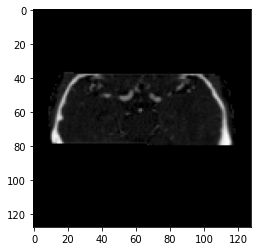

In [13]:
slice_num = 9
X_class_23 = X_val[0]
#X_train_aug4 = np.expand_dims(X_train_aug4, axis=4)
print(X_class_23.shape)
vol = np.transpose(X_class_23, (2, 1, 0,3))

gamma = [.65]

volume = np.power(vol, gamma[0]) 
volume[volume < 0] = 0

plt.imshow(volume[slice_num], cmap = 'gray')
vol.shape

1.0
LVO Patient


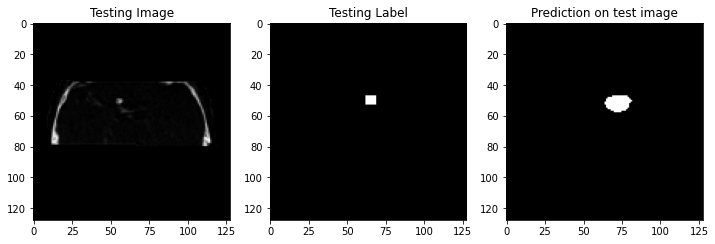

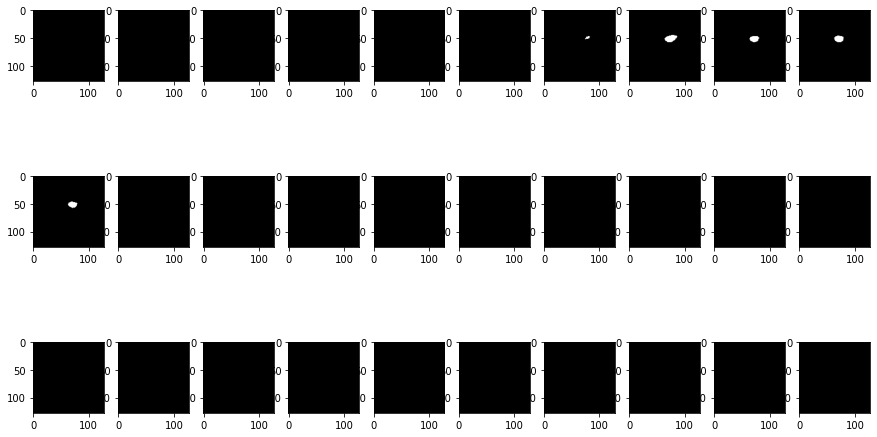

In [1768]:
THRESHOLD =0.9
class_img_number = 122     #0-119 NonLVO
test_img_1 = X_test_2[class_img_number]
test_img_2 = X_test_3[class_img_number]
ground_truth = y_test_3[class_img_number]
test_img_input_1 = np.expand_dims(test_img_1, 0)
test_img_input_2 = np.expand_dims(test_img_2, 0)
test_pred = classification_model.predict([test_img_input_2, test_img_input_1])
print(y_test_3[class_img_number])
if test_pred>THRESHOLD: 
    print('LVO Patient')
    test_img_number = class_img_number - 115
    test_img = X_val[test_img_number] ##X_val for LVO; X_test_n for non LVO
    ground_truth=y_val[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)
    test_pred1 = detection_model.predict(test_img_input)
    
    #test_prediction1 = test_pred1[0, :, :, :, 0]>=0.5
    test_prediction1 = (test_pred1[0, :, :, :, 0] > THRESHOLD).astype(np.uint8)
    ground_truth_argmax = ground_truth[:, :, :, 0]
    slice = 9
    plt.figure(figsize=(12,8))
    plt.subplot(231)
    plt.title('Testing Image')
    x_t=np.transpose(test_img, (2, 1, 0, 3))
    #x_t = x_t[:, :, :, 0]
    plt.imshow(x_t[slice], cmap='gray')
    #plt.imshow(test_img[slice,:,:,0], cmap='gray')

    plt.subplot(232)
    plt.title('Testing Label')
    y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
    plt.imshow(y_t[slice], cmap ='gray')

    plt.subplot(233)
    plt.title('Prediction on test image')
    y_p = np.transpose(test_prediction1, (2, 1, 0))
    plt.imshow(y_p[slice], cmap = 'gray')
    plt.show()

    plt.figure(figsize=(15,30))
    for i in range(30):
        plt.subplot(10, 10, i+1)
        plt.imshow(y_p[(i+1)], cmap='gray')      
else:
    print('Normal Patient')

In [873]:
#np.set_printoptions(threshold=sys.maxsize)
np.sum(test_prediction1)

12

(128, 128, 32)
(128, 128, 32)


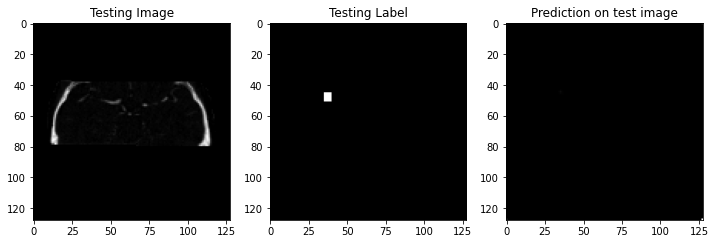

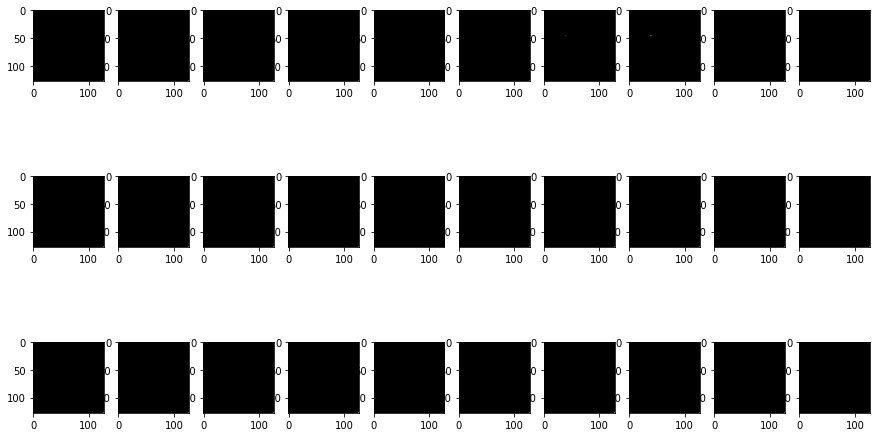

In [29]:
#     test_img_number = 0
#     test_img = X_val[test_img_number]
#     ground_truth=y_val[test_img_number]
#     test_img_input = np.expand_dims(test_img, 0)
#     test_pred1 = detection_model.predict(test_img_input)
    
#     test_prediction1 = test_pred1[0, :, :, :, 0]
#     ground_truth_argmax = ground_truth[:, :, :, 0]
#     slice = 10  #6-7 !!!
#     plt.figure(figsize=(12,8))
#     plt.subplot(231)
#     plt.title('Testing Image')
#     x_t=np.transpose(test_img, (2, 1, 0, 3))
#     #x_t = x_t[:, :, :, 0]
#     plt.imshow(x_t[slice], cmap='gray')
#     #plt.imshow(test_img[slice,:,:,0], cmap='gray')

#     plt.subplot(232)
#     plt.title('Testing Label')
#     y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
#     plt.imshow(y_t[slice], cmap ='gray')

#     plt.subplot(233)
#     plt.title('Prediction on test image')
#     y_p = np.transpose(test_prediction1, (2, 1, 0))
#     plt.imshow(y_p[slice], cmap = 'gray')
#     plt.show()

#     plt.figure(figsize=(15,30))
#     for i in range(30):
#         plt.subplot(10, 10, i+1)
#         plt.imshow(y_t[(i+1)], cmap='gray')
##############################normal patient######################################
#     test_img_number = 4
#     test_img = X_test_n[test_img_number]
#     ground_truth=y_test_n[test_img_number]
#     test_img_input = np.expand_dims(test_img, 0)
#     test_pred1 = detection_model.predict(test_img_input)
    
#     test_prediction1 = test_pred1[0, :, :, :, 0]
#     ground_truth_argmax = ground_truth[:, :, :, 0]
#     slice = 10  #6-7 !!!
#     plt.figure(figsize=(12,8))
#     plt.subplot(231)
#     plt.title('Testing Image')
#     x_t=np.transpose(test_img, (2, 1, 0, 3))
#     #x_t = x_t[:, :, :, 0]
#     plt.imshow(x_t[slice], cmap='gray')
#     #plt.imshow(test_img[slice,:,:,0], cmap='gray')

#     plt.subplot(232)
#     plt.title('Testing Label')
#     y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
#     plt.imshow(y_t[slice], cmap ='gray')

#     plt.subplot(233)
#     plt.title('Prediction on test image')
#     y_p = np.transpose(test_prediction1, (2, 1, 0))
#     plt.imshow(y_p[slice], cmap = 'gray')
#     plt.show()

#     plt.figure(figsize=(15,30))
#     for i in range(30):
#         plt.subplot(10, 10, i+1)
#         plt.imshow(y_p[(i+1)], cmap='gray')